                                                    REDES NEURAIS RECORRENTES - RNNs
                                                

As RNNs são um tipo de rede neural desenvolvida para processar dados sequenciais, como series temporais ou texto. Assim como cadeias de Markov e diferentes das MLPs tradicionais, essas redes levam em consideração o estado oculto do tempo anterior, dizendo assim que essas arquiteturas possuem um certo tipo de "memória". 

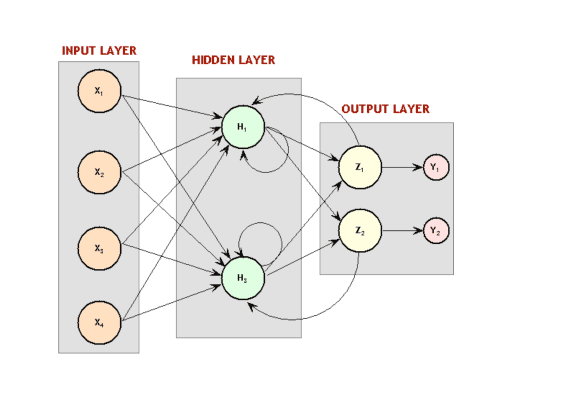

A decisão de uma rede recorrente alcançada na etapa de tempo t-1 afeta a decisão que alcançará um momento mais tarde na etapa de tempo t. Assim, as redes recorrentes têm duas fontes de entrada, o presente e o passado recente, que se combinam para determinar como respondem a novos dados. O estado oculto na etapa de tempo t é ht. É uma função da entrada na mesma etapa de tempo xt, modificada por uma matriz de peso W adicionada ao estado oculto do passo de tempo anterior ht-1 multiplicado por seu próprio estado oculto menos para a matriz de estado oculto U

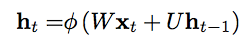

In [5]:
import pandas as pd
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow import keras

In [6]:
class PrintEveryNEpochs(tf.keras.callbacks.Callback):
    def __init__(self, N):
        super(PrintEveryNEpochs, self).__init__()
        self.N = N

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.N == 0:
            print(f"Epoch {epoch + 1}: loss = {logs['loss']}")

In [14]:
import os
os.chdir(r'D:\Mestrado\Mestrado')
print(os.getcwd())

D:\Mestrado\Mestrado


In [19]:
df = pd.read_excel('RJ_Reconstrucao_Moluscos_2024_06_25.xlsx')


In [20]:
x0 = df[['Ano', 'Lula_art']].dropna().values

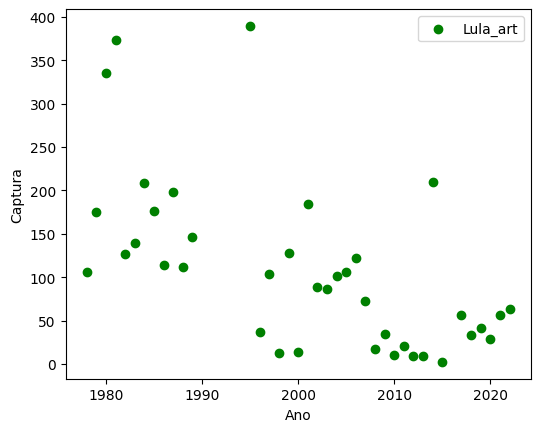

In [21]:
plt.figure(figsize=(6, 4.8))
plt.scatter(x0[:, 0], x0[:, 1], c='g', label='Lula_art')
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.legend()
plt.show()

In [23]:
df_x0= pd.DataFrame(x0, columns= ['Ano', 'Lula_art'])
df_x0= df_x0.drop_duplicates(subset= 'Lula_art')

In [24]:
x = np.array(df_x0['Ano'], dtype=np.float32).reshape(-1, 1)
y = np.array(df_x0['Lula_art'], dtype=np.float32).reshape(-1, 1)

x_mean = np.mean(x)
x_std = np.std(x)
x_normalized = (x - x_mean) / x_std

y_mean = np.mean(y)
y_std = np.std(y)
y_normalized = (y - y_mean) / y_std

C:\Users\Renan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.1520.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


Epoch 0: loss = 0.7220360040664673
Epoch 100: loss = 0.7853808403015137
Epoch 200: loss = 0.7454802393913269
Epoch 300: loss = 0.37254923582077026
Epoch 400: loss = 0.4246501922607422
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


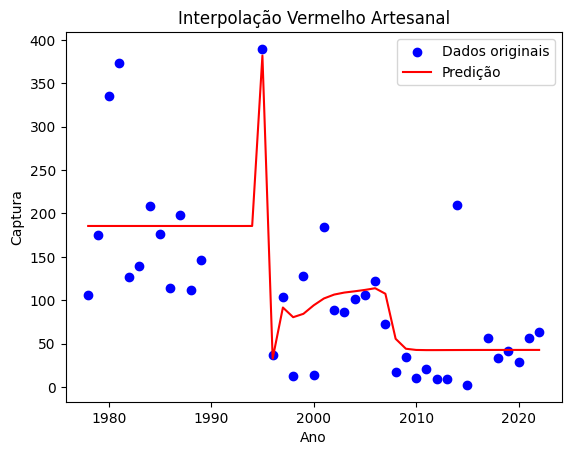

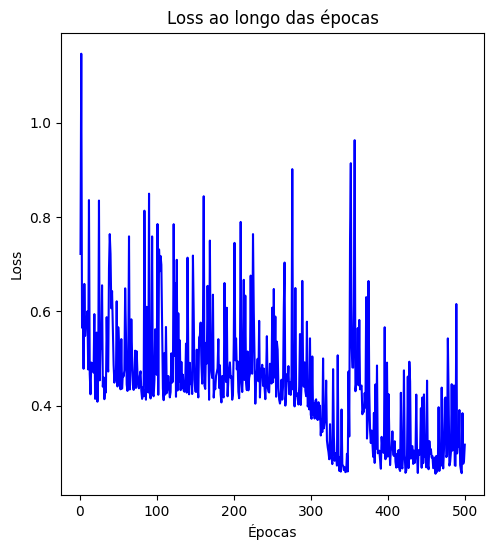

In [36]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, activation='tanh', return_sequences=True, input_shape=(None, 1)),
    tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True),
    tf.keras.layers.LSTM(128, activation='tanh', return_sequences=True),
    tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True),
    tf.keras.layers.LSTM(32, activation='tanh'),
    tf.keras.layers.Dense(1, activation='linear')
])


opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss='mse', metrics=['mse'])

print_every_100_epochs = PrintEveryNEpochs(N=100) 

history = model.fit(
    x_normalized, y_normalized, 
    epochs=500, 
    batch_size=12, 
    steps_per_epoch=50, 
    verbose=0,  
    callbacks=[print_every_100_epochs]
)




x_all = np.arange(min(x.flatten()), max(x.flatten()) + 1).reshape(-1, 1)
x_all_normalized = (x_all - x_mean) / x_std
y_all_predicted_normalized = model.predict(x_all_normalized.reshape(-1, 1, 1))
y_all_predicted = y_all_predicted_normalized * y_std + y_mean

df_predicted = pd.DataFrame({'Ano': x.flatten(), 'Captura Original': y.flatten()})
df_all_predicted = pd.DataFrame({'Ano': x_all.flatten(), 'Captura Preditos': y_all_predicted.flatten()})
df_combined = pd.merge(df_predicted, df_all_predicted, on='Ano', how='right').sort_values(by='Ano')


plt.scatter(df_combined['Ano'], df_combined['Captura Original'], color='blue', label='Dados originais')
plt.plot(df_combined['Ano'], df_combined['Captura Preditos'], color='red', label='Predição')
plt.xlabel('Ano')
plt.ylabel('Captura')
plt.title('Interpolação Vermelho Artesanal')
plt.legend()
plt.show()


loss_values = history.history['loss']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'b')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.title('Loss ao longo das épocas')
plt.show()
